In [1]:
%matplotlib inline
import rebound
import reboundx
from reboundx import constants
import numpy as np
import datetime
from astropy import constants as const
import pandas as pd
import matplotlib.pyplot as plt
from src import nbody as nb
from decimal import Decimal
plt.rcParams.update({'font.size': 14})
logpath = '/storage/home/len56/work/warm_jupiters/data/datalog.csv'
sapath = '/storage/home/len56/work/warm_jupiters/simulation_archive/'

cols = ['tag','tmax','Nout','GR','tides','epsilon','notes','runtime']

years = 2.*np.pi



In [ ]:
tag = datetime.datetime.now().isoformat().replace('T','').replace(':','')\
                                             .replace('-','').replace('.','')[2:-5]
logpath = '/storage/home/len56/work/warm_jupiters/data/datalog.csv'
# df = pd.read_csv(logpath)
df = pd.read_csv(logpath)
df = df.append({'tag':tag,
               'GR':GR,
               'tides':tides,
               'epsilon':epsilon,
               'runtime':'RUNNING...'},ignore_index=True)

df = pd.read_csv(logpath)
df.set_index('tag', inplace=True)
df.loc[float(tag),'runtime'] = 678
df

In [ ]:
def update_log(tmax,Nout,GR,tides,epsilon,notes):
    start = datetime.datetime.now()
    tag = start.isoformat().replace('T','').replace(':','')\
                                             .replace('-','').replace('.','')[2:-5]
    df = pd.read_csv(logpath)
    df = df.append({'tag':tag,
                   'date': str(start).split()[0],
                   'tmax': str(round(tmax/(2.*np.pi))),
                   'Nout':str(round(Nout)),
                   'GR':str(GR),
                   'tides':str(tides),
                   'epsilon':epsilon,
                   'notes':notes,
                   'runtime':'RUNNING...'},
                   ignore_index=True)
    df.to_csv(logpath,index=False)
    del df
    return tag,start

def makesim(three_body=True,inner_mass=True):
    """Makes a rebound.Simulation() of system HD 147018."""
    sim = rebound.Simulation()
    sim.add(m = 0.927)
    
    m_inner = 2.12*M_jup/M_sun
    if inner_mass == False:
        m_inner = 0.0
    else: pass
    sim.add(m = m_inner,
            a = 0.2389, #1.0,
            e = 0.4686, #0.9,
            inc = np.radians(35.614629), #np.radians(65.0),
            Omega = np.radians(0.0),
            omega = np.radians(66.0054), #np.radians(38.4),
            M = np.radians(0.698350))
    
    if three_body == True:
        sim.add(m = 6.59*M_jup/M_sun,
                a =1.923,
                e = 0.133,
                inc = np.radians(3.3853710), #0.0,
                Omega = np.radians(180.0),
                omega = np.radians(136.865), #np.radians(17.2),
                M = np.radians(-293.214))
    else: pass
    return sim

def makesim_past():
    """Makes a rebound.Simulation() of system past configuration
    of HD 147018, based on Fig. 4 of Dawson & Chiang (2014)
    https://arxiv.org/abs/1410.2604"""
    sim = rebound.Simulation()
    sim.add(m = 0.927)
    sim.add(m = 0.0, #2.12*M_jup/M_sun,
            a = 1.0,
            e = 0.9,
            inc = np.radians(65.0),
            Omega = np.radians(0.0),
            omega = np.radians(38.4),
            M = np.radians(0.698350))
    sim.add(m = 6.59*M_jup/M_sun,
            a =1.923,
            e = 0.133,
            inc = 0.0,
            Omega = np.radians(180.0),
            omega = np.radians(17.2),
            M = np.radians(-293.214))
    return sim
    
def runsim(sim,tmax,Nout,GR=False,tides=False,Q=1.0e5,epsilon=1e-9,notes='-'):
    sim.integrator='ias15'
    sim.ri_ias15.epsilon = epsilon
    sim.move_to_com()
    interval =  tmax/Nout
    ps = sim.particles
    rebx = reboundx.Extras(sim)
     
    if GR == True:
        gr = rebx.load_force("gr")
        rebx.add_force(gr)
        gr.params["c"] = constants.C  

    if tides == True:
        mod = rebx.load_operator("modify_orbits_direct2")
        rebx.add_operator(mod)
        tau = Q/(3.0*k)*((2.12*M_jup/M_sun)/ps[0].m)/(R_jup/au)**5.0
        ps[1].params["tau_e"] = tau
        
    tag,start = update_log(tmax,Nout,GR,tides,epsilon,notes)
    file = sapath+'sa'+tag+'.bin'
    sim.automateSimulationArchive(file,interval=interval,deletefile=True)
    
    sim.integrate(tmax,exact_finish_time=0)
    
    runtime = datetime.datetime.now() - start
    df = pd.read_csv(logpath)
    df.set_index('tag', inplace=True)
    df.loc[float(tag),'runtime'] = runtime.total_seconds()
    df.to_csv(logpath,index=True)
    del df
    
    return file

    
def calc_imut(inc1,inc2,Omega1,Omega2):
    deltaOmega = Omega1-Omega2
    cosimut = np.cos(inc1)*np.cos(inc2)+np.sin(inc1)*np.sin(inc2)*np.cos(deltaOmega)
    imut = np.arccos(cosimut)
    return np.array(imut)

def calc_deltapomega(pomega1,pomega2):
    deltapom = (pomega2-pomega1+2.*np.pi)%(2.*np.pi)
    return np.array(deltapom)


    
    

In [10]:
tides = True
GR = True
epsilon = 1e-6
years = 2.*np.pi
tmax = 1000*years
Nout = 1000
notes = 'test'
sim = nb.makesim()
file = nb.runsim(sim,tmax=tmax,Nout=Nout,GR=GR,tides=tides,epsilon=epsilon)

/storage/home/len56/.local/lib/python3.6/site-packages/rebound/simulation.py:664: RuntimeWarning: REBOUNDx: Operators that affect particle trajectories with adaptive timesteps can give spurious results. Use sim.ri_ias15.epsilon=0 for fixed timestep with IAS, or use a different integrator.
  warnings.warn(msg[1:], RuntimeWarning)


In [2]:
df = pd.read_csv(logpath).astype(str)[cols]
df

,tag,tmax,Nout,GR,tides,epsilon,notes,runtime
0,1912041705188,100,100,False,False,1e-06,-,0.64275
1,1912041705309,100,100,False,False,1e-06,-,0.644125
2,1912041705446,1000,100,True,False,1e-06,-,12.181869
3,1912041709116,1000,1000,True,True,1e-06,-,14.122538
4,1912041734320,1000,1000,False,False,0.001,-,3.6505449999999997
5,1912041736259,10000,1000,False,False,0.001,-,27.667774
6,1912041737233,100000,1000,False,False,0.001,-,728.861006
7,1912041738384,1000,1000,True,False,0.001,-,19.899527
8,1912041739104,10000,1000,True,False,0.001,-,156.285744
9,1912041739333,100000,1000,True,False,0.001,-,1583.245954


In [84]:
# df = pd.read_csv(logpath)
# df.set_index('tag', inplace=True)
# #df.loc[1912041951452,'runtime'] = 'interrupted'
# df = df.drop(1912050746096)
# df.to_csv(logpath,index=True)

In [2]:
c1 = 'gray'
c2 = 'black'
c3 = 'blue'
c4 = 'red'
ms = 10
mfc = 'none'
ls3 = '-'
ls6 = '-'
ls9 = '-'
eps3G = df[(df['epsilon']=='0.001')&(df['GR']=='True')&(df['tides']=='False')]
eps3T = df[(df['epsilon']=='0.001')&(df['GR']=='False')&(df['tides']=='True')]
eps3n = df[(df['epsilon']=='0.001')&(df['GR']=='False')&(df['tides']=='False')]
eps3b = df[(df['epsilon']=='0.001')&(df['GR']=='True')&(df['tides']=='True')]

eps6n = df[(df['epsilon']=='1e-06')&(df['GR']=='False')&(df['tides']=='False')&(df['notes']=='benchmark')]
eps6T = df[(df['epsilon']=='1e-06')&(df['GR']=='False')&(df['tides']=='True')]
eps6G = df[(df['epsilon']=='1e-06')&(df['GR']=='True')&(df['tides']=='False')&(df['notes']=='benchmark')]
eps6b = df[(df['epsilon']=='1e-06')&(df['GR']=='True')&(df['tides']=='True')&(df['notes']=='benchmark')]

eps9n = df[(df['epsilon']=='1e-09')&(df['GR']=='False')&(df['tides']=='False')&(df['notes']=='benchmark')]
eps9T = df[(df['epsilon']=='1e-09')&(df['GR']=='False')&(df['tides']=='True')]
eps9G = df[(df['epsilon']=='1e-09')&(df['GR']=='True')&(df['tides']=='False')&(df['notes']=='benchmark')]
eps9b = df[(df['epsilon']=='1e-09')&(df['GR']=='True')&(df['tides']=='True')&(df['notes']=='benchmark')]

# plt.plot(eps3G['tmax'].astype(float),eps3G['runtime'].astype(float),ls3,c=c4,ms=ms,mfc=mfc)
# plt.plot(eps3T['tmax'].astype(float),eps3T['runtime'].astype(float),ls3,c=c3,ms=ms,mfc=mfc)
# plt.plot(eps3b['tmax'].astype(float),eps3b['runtime'].astype(float),ls3,c=c2,ms=ms,mfc=mfc)
# plt.plot(eps3n['tmax'].astype(float),eps3n['runtime'].astype(float),ls3,c=c1,ms=ms,mfc=mfc)

# plt.plot(eps6G['tmax'].astype(float),eps6G['runtime'].astype(float),ls6,c=c4,ms=ms)
# plt.plot(eps6n['tmax'].astype(float),eps6n['runtime'].astype(float),ls6,c=c1,ms=ms)
# plt.plot(eps6T['tmax'].astype(float),eps6T['runtime'].astype(float),ls6,c=c3,ms=ms)
# plt.plot(eps6b['tmax'].astype(float),eps6b['runtime'].astype(float),ls6,c=c2,ms=ms)


# plt.plot(eps9G['tmax'].astype(float),eps9G['runtime'].astype(float),ls9,c=c4,ms=ms,mfc=mfc)
# plt.plot(eps9n['tmax'].astype(float),eps9n['runtime'].astype(float),ls9,c=c1,ms=ms,mfc=mfc)
# plt.plot(eps9T['tmax'].astype(float),eps9T['runtime'].astype(float),ls9,c=c3,ms=ms,mfc=mfc)
# plt.plot(eps9b['tmax'].astype(float),eps9b['runtime'].astype(float),ls9,c=c2,ms=ms,mfc=mfc)

# plt.plot(eps9b['tmax'].astype(float),eps9b['runtime'].astype(float),label='1e-09')
# plt.plot(eps6b['tmax'].astype(float),eps6b['runtime'].astype(float),label='1e-06')
# plt.plot(eps3b['tmax'].astype(float),eps3b['runtime'].astype(float),label='1e-03')
# plt.legend()
# plt.yscale('log')
# plt.xscale('log')


NameError: name 'df' is not defined

In [122]:



# plt.plot(eps3G['tmax'].astype(float),eps3G['runtime'].astype(float),'-o')
# plt.plot(eps3b['tmax'].astype(float),eps3b['runtime'].astype(float),'-o')
#plt.yscale('log')
#plt.xscale('log')
eps9T = df[(df['epsilon']=='1e-09')&(df['GR']=='False')&(df['tides']=='True')]
eps9T

,tag,tmax,Nout,GR,tides,epsilon,notes,runtime
28,1912050733187,1000,1000,False,True,1e-09,benchmark,26.541537
32,1912050735253,10000,1000,False,True,1e-09,benchmark,439.21248


/storage/home/len56/.local/lib/python3.6/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


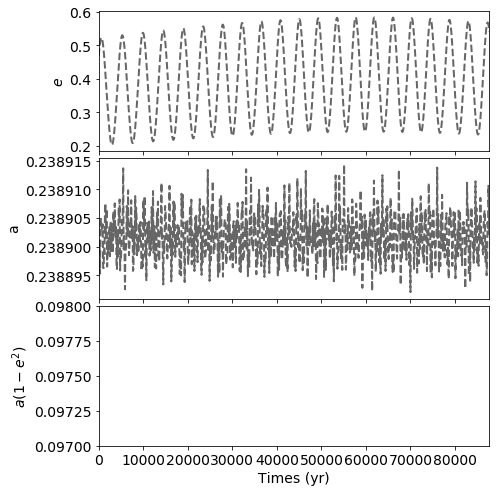

In [13]:
file = sapath+'sa1912041947562.bin'
sa = rebound.SimulationArchive(file)
e = np.zeros(len(sa))
a = np.zeros(len(sa))
times = np.zeros(len(sa))
for i, sim in enumerate(sa):
    ps = sim.particles
    e[i] = ps[1].e
    a[i] = ps[1].a
    times[i] = sim.t
    
times = times/(2.*np.pi)  

fig, ax = plt.subplots(3,1,figsize=(7,8),sharex=True)
c='black'
ls='--'
lw=2
alpha=0.6
ax[0].plot(times,e,c=c,ls=ls,lw=lw,alpha=alpha)
ax[0].margins(x=0)
ax[0].set_ylabel(r'$e$')
ax[1].plot(times,a,c=c,ls=ls,lw=lw,alpha=alpha)
ax[1].margins(x=0)
ax[1].set_ylabel(r'a')
ax[2].plot(times,a*(1.-e*e),c=c,ls=ls,lw=lw,alpha=alpha)
ax[2].set_ylim(0.097,0.098)
ax[2].margins(x=0)
ax[2].set_ylabel(r'$a(1-e^2)$')
ax[2].set_xlabel('Times (yr)')
plt.subplots_adjust(hspace=0.05)

In [10]:
times[-1]

87700.00077121967

In [15]:
times[-1]

87700.00077121967